# 分子動力学シミュレーション

## TL;DR

- MDシミュレーションでは古典力学の運動方程式に則った計算方法で、全ての原子の位置と速度の時間発展を露わに観察できる。
- 時間スケールの制約があり一般的に数nsから数十nsぐらいが上限。その時間内に発現しない現象は別の計算手法を検討する必要がある。
- MDシミュレーションには再現したい状態に応じて様々な状態（アンサンブル）があり、最も単純なアンサンブルはNVEアンサンブルという。
- NVEアンサンブルでは全エネルギー保存則が成立し、計算精度および計算時間の観点から、時間ステップサイズを適切に設定する必要がある。


</br>

この章では系の時間発展をシミュレーションする、 **分子動力学シミュレーション（Molecular dynamics, MD）** について学びます。

MDシミュレーションでは個々の原子の軌道の時間発展を露わに取り扱うシミュレーションで、古典力学の運動方程式を積分することによって計算対象である原子の座標と速度を逐次計算していく手法です。この計算手法自体は原子間に働く力やエネルギーのモデルとは独立した理論で、古くから分子シミュレーションの分野で用いられてきました。従って、理論的な背景や事例等は多くの書籍や文献が多く存在するのでそれらを確認していただければと思います。（参考文献：[1-3]） 本チュートリアルではあくまでMatlantisを使って**実践的に**これらの計算を実行するために必要な知識を習得するところが目的となっています。

早速ですが具体的な事例を通して、どんなことがMDシミュレーションで観察出来るかみてみましょう。

 - https://wiki.fysik.dtu.dk/ase/tutorials/md/md.html

## 事前準備 - 必要なライブラリのインストール

本章ではところどころ、ASE上で簡易に利用できる古典力場であるASAP3のEMT力場を利用しています。古典力場であるため精度や用途はかなり限定的ですがシンプルかつ高速で実行可能なのでチュートリアルとして事例を示すには十分な機能を持っています。ちなみにASAP3-EMTで利用可能な元素はNi、Cu、Pd、Ag、Pt、Auとこれらの合金に限定されます。インストールの仕方は以下のとおりです。

In [ ]:
!pip install --upgrade asap3

ASAP3-EMTに関する詳細は<a href="https://wiki.fysik.dtu.dk/asap/asap">ASAPのサイト</a>をご確認ください。

## MDシミュレーションでなにが出来るか

以下の事例では金属Al構造の溶融状態をMDシミュレーションで再現しています。ご存知の通りアルミニウムは我々がよく見かける物質で工業的に非常に重要な金属であり、その特性も良く知られています。融点は660.3 °C（933.45 K）で、常圧下では幅広い温度領域で面心立方格子（face-centered cubic, fcc）構造を持ちます。以下はそのfcc-Al構造を初期温度1600 Kに過熱して熔融させる過程を示したものです。計算時間は100 psecです。

</br>
<figure style="text-align:center">
  <img src="../assets/ch6/Fig6-1_fcc-Al_NVE_1600Kstart.png" alt="fcc-Al_NVE_1600Kstart">
  <figcaption>Fig6-1a. Melting of fcc-Al in NVE ensemble starting at 1600 K</figcaption>
  <figcaption>         (File: ../input/ch6/6-1_fcc-Al_NVE_1600Kstart.traj)</figcaption>
</figure>

最初はきれいにfccの結晶構造に配置されたAl原子ですが、計算が進むにつれ徐々に構造が乱れ、段々とシミュレーションセルの外側に拡散していく様子がうかがえます。このように**MDシミュレーションでは実際に原子が時間発展とともにどのような軌道を描くか詳細に観察することが可能です**。

## アルミニウムの溶融シミュレーション

それでは以下に、上記のfcc-Alの溶融過程を再現するのに用いたMDシミュレーションのサンプルコードを示します。今回は計算の高速化のためASAP3のEMT力場を用いています。（ユーザーのpython環境でこの力場を用いる際は始めに`pip install asap3`を実行してasap3のパッケージをインストールしてください。）以下の計算は100 psec実行しますが、数十秒ほどで計算が完了します。

In [2]:
%%time
import os
from asap3 import EMT
calculator = EMT()

from ase.build import bulk
from ase.md.velocitydistribution import MaxwellBoltzmannDistribution,Stationary
from ase.md.verlet import VelocityVerlet
from ase.md import MDLogger
from ase import units
from time import perf_counter
import numpy as np

# Set up a fcc-Al crystal
atoms = bulk("Al","fcc",a=4.3,cubic=True)
atoms.pbc = True
atoms *= 3
print("atoms = ",atoms)

# Set calculator (EMT in this case)
atoms.calc = calculator

# input parameters
time_step    = 1.0      # MD step size in fsec
temperature  = 1600     # Temperature in Kelvin
num_md_steps = 100000   # Total number of MD steps
num_interval = 1000     # Print out interval for .log and .traj

# Set the momenta corresponding to the given "temperature"
MaxwellBoltzmannDistribution(atoms, temperature_K=temperature,force_temp=True)
Stationary(atoms)  # Set zero total momentum to avoid drifting

# Set output filenames
output_filename = "./output/ch6/liquid-Al_NVE_1.0fs_test"
log_filename = output_filename + ".log"
print("log_filename = ",log_filename)
traj_filename = output_filename + ".traj"
print("traj_filename = ",traj_filename)

# Remove old files if they exist
if os.path.exists(log_filename): os.remove(log_filename)
if os.path.exists(traj_filename): os.remove(traj_filename)

# Define the MD dynamics class object
dyn = VelocityVerlet(atoms, 
                     time_step * units.fs,
                     trajectory = traj_filename,
                     loginterval=num_interval
                    )  

# Print statements
def print_dyn():
    imd = dyn.get_number_of_steps()
    time_md = time_step*imd
    etot  = atoms.get_total_energy()
    ekin  = atoms.get_kinetic_energy()
    epot  = atoms.get_potential_energy()
    temp_K = atoms.get_temperature()
    print(f"   {imd: >3}     {etot:.9f}     {ekin:.9f}    {epot:.9f}   {temp_K:.2f}")

dyn.attach(print_dyn, interval=num_interval)

# Set MD logger
dyn.attach(MDLogger(dyn, atoms, log_filename, header=True, stress=False,peratom=False, mode="w"), interval=num_interval)

# Now run MD simulation
print(f"\n    imd     Etot(eV)    Ekin(eV)    Epot(eV)    T(K)")
dyn.run(num_md_steps)

print("\nNormal termination of the MD run!")

atoms =  Atoms(symbols='Al108', pbc=True, cell=[12.899999999999999, 12.899999999999999, 12.899999999999999])
log_filename =  ./output/ch6/liquid-Al_NVE_1.0fs_test.log
traj_filename =  ./output/ch6/liquid-Al_NVE_1.0fs_test.traj

    imd     Etot(eV)    Ekin(eV)    Epot(eV)    T(K)
     0     32.139701294     22.336120234    9.803581060   1600.00
   1000     32.144889111     9.851785137    22.293103974   705.71
   2000     32.144634514     10.538523047    21.606111466   754.90
   3000     32.144643608     11.205207875    20.939435733   802.66
   4000     32.144360371     10.628376834    21.515983537   761.34
   5000     32.144745056     10.642859695    21.501885362   762.38
   6000     32.144964346     9.673146214    22.471818131   692.92
   7000     32.145003412     10.329285833    21.815717579   739.92
   8000     32.144790609     10.798458531    21.346332078   773.52
   9000     32.145198824     9.717769786    22.427429038   696.11
   10000     32.144979661     9.871641249    22.27333

プログラムの流れはスクリプト内のコメントを見ながら流れを追っていけばだいたい理解できるとは思いますが重要なポイントのみについて解説します。


（１）初速度分布

構造作成、計算パラメーターの設定が終わったのち、各原子の初速度は指定の温度に対応した<a href="https://ja.wikipedia.org/wiki/%E3%83%9E%E3%82%AF%E3%82%B9%E3%82%A6%E3%82%A7%E3%83%AB%E5%88%86%E5%B8%83">Maxwell-Boltzmann分布</a>に従う速度分布を与えます。上記コードでは、 `MaxwellBoltzmannDistribution` を用いて行っています。この方法で与えた初速度には系全体の運動量の任意性があるため、このままでは系全体がドリフトする可能性があります。なのでMaxwell-BoltzmannDistributionで初速度を与えた後に`Stationary`という関数で系全体の運動量をゼロとし、質量中心の座標を固定します。NVEの事例だけでなく、この後出てくる温度制御や圧力制御を伴うシミュレーションでも重要になります。

（２）MDの実行

今回は、`VelocityVerlet`というクラスを用いることで、[速度ベルレ法](https://ja.wikipedia.org/wiki/%E3%83%99%E3%83%AC%E3%81%AE%E6%96%B9%E6%B3%95)によるMDを実行しています。
`dyn.run(num_md_steps)` の箇所で実際にMDの実行が行われています。
今回の設定では、`time_step=1.0`として、1stepあたり1fs = $1 \times 10^{-15}$ secの時間幅で、`num_md_steps=100000` step実行しています。

（3）計算結果の記録

このスクリプトには`print_dyn`という標準出力（notebook上へのデータの出力）にエネルギーや温度の値を出力する関数があります。その他にも`MDLogger`という関数があり、これは指定したLogファイルの中にエネルギー、温度、応力情報を出力します。独自に計算結果をファイル出力する機構を作っても良いですが、デフォルトで備わっているLoggerで大抵のアプリケーションに必要な情報は得られるので活用をお薦めします。

MD実行後、軌跡の可視化は以下のように行なえます。

In [3]:
from ase.io import Trajectory
from pfcc_extras.visualize.view import view_ngl


traj = Trajectory(traj_filename)
view_ngl(traj)

In [4]:
from pfcc_extras.visualize.povray import traj_to_apng
from IPython.display import Image


traj_to_apng(traj, f"output/Fig6-1_fcc-Al_NVE_1600Kstart.png", rotation="0x,0y,0z", clean=True, n_jobs=16)

# See Fig6-1a
#Image(url="output/Fig6-1_fcc-Al_NVE_1600Kstart.png")

[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:   13.9s
[Parallel(n_jobs=16)]: Done 101 out of 101 | elapsed:   59.4s finished


## NVEアンサンブルにおける物性値のヒストリー

各原子の速度（すなわち運動量）も分かるため各種エネルギーの履歴を追うことも出来ます。例えば、以下は上のfcc-Alの溶融の際の全エネルギー（Tot.E.）、ポテンシャルエネルギー（P.E.）、運動エネルギー（K.E.）、そして温度（Temp.）の時間プロファイルです。


In [5]:
import pandas as pd

df = pd.read_csv(log_filename, delim_whitespace=True)
df

,Time[ps],Etot[eV],Epot[eV],Ekin[eV],T[K]
0,0.0,32.140,9.804,22.336,1600.0
1,1.0,32.145,22.293,9.852,705.7
2,2.0,32.145,21.606,10.539,754.9
3,3.0,32.145,20.939,11.205,802.7
4,4.0,32.144,21.516,10.628,761.3
...,...,...,...,...,...
96,96.0,32.145,23.186,8.959,641.8
97,97.0,32.144,21.514,10.630,761.4
98,98.0,32.145,22.039,10.106,723.9
99,99.0,32.145,22.386,9.759,699.0


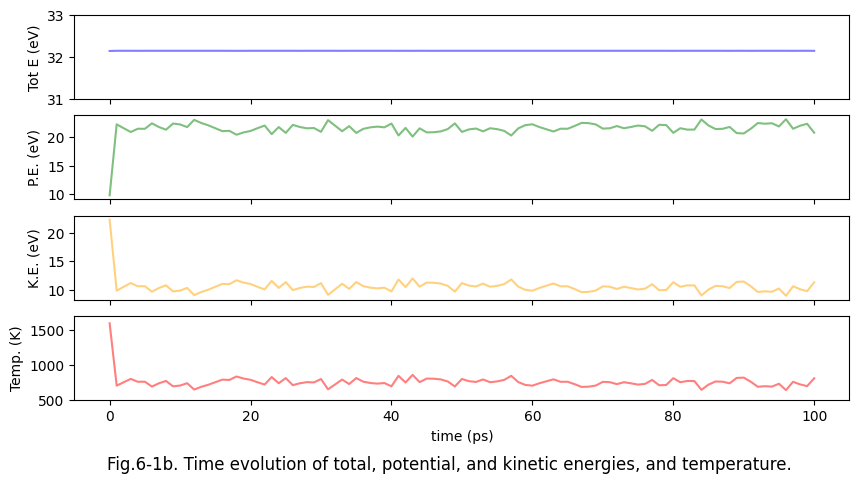

In [6]:
import numpy as np
import matplotlib.pyplot as plt


fig = plt.figure(figsize=(10, 5))

#color = 'tab:grey'
ax1 = fig.add_subplot(4, 1, 1)
ax1.set_xticklabels([])  
ax1.set_ylabel('Tot E (eV)')  
ax1.set_ylim([31.,33.])
ax1.plot(df["Time[ps]"], df["Etot[eV]"], color="blue",alpha=0.5)

ax2 = fig.add_subplot(4, 1, 2)
ax2.set_xticklabels([])  
ax2.set_ylabel('P.E. (eV)')  
ax2.plot(df["Time[ps]"], df["Epot[eV]"], color="green",alpha=0.5)

ax3 = fig.add_subplot(4, 1, 3)
ax3.set_xticklabels([])  
ax3.set_ylabel('K.E. (eV)')  
ax3.plot(df["Time[ps]"], df["Ekin[eV]"], color="orange",alpha=0.5)

ax4 = fig.add_subplot(4, 1, 4)
ax4.set_xlabel('time (ps)')  
ax4.set_ylabel('Temp. (K)')  
ax4.plot(df["Time[ps]"], df["T[K]"], color="red",alpha=0.5)
ax4.set_ylim([500., 1700])

fig.suptitle("Fig.6-1b. Time evolution of total, potential, and kinetic energies, and temperature.", y=0)

#plt.savefig("6-1_liquid-Al_NVE_1.0fs_test_E_vs_t.png")  # <- Use if saving to an image file is desired
plt.show()

1-5節 でも出てきましたが、系の全エネルギー $E$ (Total energy) は、運動エネルギー $K$ (Kinetic energy)と、ポテンシャルエネルギー $V$ (Potential energy)で表されます。

$$ E = K + V $$

このうち、原子の運動エネルギー$K$は古典力学の表式を用い以下のように計算できます。

$$ K = \sum_{i=1}^{N} \frac{1}{2} m_i {\mathbf{v}}_i^2 = \sum_{i=1}^{N} \frac{{\mathbf{p}}_i^2}{2 m_i}  $$

ここで $m_i, \mathbf{v}_i, \mathbf{p}_i$ はそれぞれ各原子の質量 (mass) 、速度 (velocity)および運動量 (momenta, $\mathbf{p}=m\mathbf{v}$)です。ここで系の温度と運動エネルギーはほぼ同義で、以下のような関係で定義されます。

\$$ K = \frac{3}{2} k_B T$$


今回のケースでは初期温度を1600 Kと設定し、あとは古典力学の運動方程式に則って自然に系を時間発展させています。従って特に外力もないのでエネルギー保存則が守られ全エネルギーが数値誤差の範囲で一定に保たれます。そしてかなり早い段階で温度が低下し、運動エネルギーとポテンシャルエネルギーのそれぞれに<a href="https://ja.wikipedia.org/wiki/%E3%82%A8%E3%83%8D%E3%83%AB%E3%82%AE%E3%83%BC%E7%AD%89%E9%85%8D%E5%88%86%E3%81%AE%E6%B3%95%E5%89%87">エネルギー分配則</a>が働き、最終的に温度は初期温度の半分程度に落ち着きます。自然界では実際に物質はそのようにふるまい、今回のような最もシンプルなMDシミュレーションではそういった状況を再現します。このような計算対象である系の状態分布を<a href="https://ja.wikipedia.org/wiki/%E3%83%9F%E3%82%AF%E3%83%AD%E3%82%AB%E3%83%8E%E3%83%8B%E3%82%AB%E3%83%AB%E3%82%A2%E3%83%B3%E3%82%B5%E3%83%B3%E3%83%96%E3%83%AB">**NVEアンサンブル**</a>と言います。（または小正準集団アンサンブル。NVEのNは原子数、Vは体積、Eは全エネルギーが一定であることを表します。）ちなみに、ここでいう<a href="https://ja.wikipedia.org/wiki/%E7%B5%B1%E8%A8%88%E9%9B%86%E5%9B%A3">アンサンブル</a>とは統計力学の考え方で物質の状態分布のことを指します。

## NVEアンサンブルにおけるMDシミュレーションの設定

さて、上記のNVEアンサンブルのMDシミュレーションでは初期温度や計算時間のような計算条件を設定する必要があります。それ以外にも比較的自明ではないパラメーターとしてMDのタイムステップを設定する必要があります。このMDのタイムステップはどのように設定したらよいでしょうか？

答えは求めている計算精度に依存します。NVEアンサンブルでは2階の常微分方程式である古典の運動方程式解くわけですが、この積分プロセスの精度がタイムステップの大きさで決まります。（積分手法の詳細については本節の最後に記載します。）タイムステップサイズを変えた時の全エネルギーがどのように変化するか見てみましょう。計算時間は仮に1 nsecとします。（古典MDなどで良く用いられる時間スケールです。）

<p>
<figure style="text-align: center">
    <img src="../assets/ch6/Fig6-1_Etot_vs_dt.png">
    <figcaption align = "center">Fig.6-1c. Time evolution of the total energy with respect to time step size.</figcaption>
</figure>
</p>
</br>


上記はタイムステップを0.5から5.0 fsecまで変化させたときの計算結果です。本来一定であるはずの全エネルギーが、タイムステップが大きいときに時間の経過とともに大きくぶれてしまっていることが確認できます。

全エネルギーの時間依存性確認のため、上記のMDシミュレーションスクリプトの`time_step` 引数を変えて実行し、そのエネルギープロファイルを比較してみてください。
可視化にあたっては、上記Fig.6-1b の可視化コードを参考にしてください。

上記の計算結果からMDのタイムステップサイズを変化し、横軸をステップサイズ、縦軸を全エネルギーの揺らぎから得られたRMSEをプロットすると以下のようになります。

<p class="aligncenter">
<figure style="text-align: center">
    <img src="../assets/ch6/Fig6-1_Etot-RMSE_vs_dt.png">
    <figcaption align = "center">Fig.6-1d. Total energy ERMSE as a function of MD step size.</figcaption>
</figure>
</p>
</br>

縦軸は原子ひとつ辺りのエネルギーです。Log-logプロットで概ね直線上にのることが見て取れます。単位原子当たりの値にして、0.25 fsで1.2e-6 eVから5.0 fsで6e-5 fsまで変化することが分かります。この場合原子数は108原子なので、系全体で1e-4 eVから1e-3 eV変化しうることが確認できます。

エネルギーの観点では時間ステップを1 fsecとすると、1 nsecのシミュレーションを100原子系で0.5 meV程度、1000原子系だと約5 meV程度の誤差が予想されます。もちろん計算したい物性などによりますが、たいていの計算では十分な精度ではないでしょうか？これが例えば計算時間を稼ぎたいからとタイムステップを5 fsecとするとほぼ一桁誤差が大きくなります。今後MD計算を活用するうえで、この計算精度がどの程度かというのは頭の片隅に止めておく必要があります。

## その他のアンサンブルとMDシミュレーション

本節の最後にNVEアンサンブル以外のMDシミュレーション法について触れておきます。

NVEアンサンブルのMDシミュレーションはシンプルかつパワフルな計算手法ですが、我々が一般に観察したい現象を再現するには不都合な点が多く存在します。
NVEのシミュレーションは計算対象のセルそれそのものが全てであり、外界というものが存在しません。しかし我々が実際に観察したいミクロな世界にはそれを取り巻く環境が存在します。外部環境の温度や圧力の影響により、計算対象の状態が変化しますが、これはNVEアンサンブルの範疇では再現が出来ません。

このため統計力学の世界ではcanonicalアンサンブル（NVT）、isothermal-isobaricアンサンブル（NPT）、等をはじめ様々な状態分布があり、それらを活用することで特定の条件下での計算が可能になります。次節以降ではこれらの統計力学アンサンブル下での計算方法について学びます。

## 参考文献

[1] M.P. Allen and D.J. Tildesley, "Computer simulaiton of liquid", 2nd Ed., Oxford University Press (2017) ISBN 978-0-19-880319-5. [DOI:10.1093/oso/9780198803195.001.0001](https://doi.org/10.1093/oso/9780198803195.001.0001)

[2] D. Frenkel and B. Smit "Understanding molecular simulation - from algorithms to applications", 2nd Ed., Academic Press (2002) ISBN 978-0-12-267351-1. [DOI:10.1016/B978-0-12-267351-1.X5000-7](https://doi.org/10.1016/B978-0-12-267351-1.X5000-7)

[3] M.E. Tuckerman, "Statistical mechanics: Theory and molecular simulation", Oxford University Press (2010) ISBN 978-0-19-852526-4. https://global.oup.com/academic/product/statistical-mechanics-9780198525264?q=Statistical%20mechanics:%20Theory%20and%20molecular%20simulation&cc=gb&lang=en#
